In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')



In [ ]:
# Load data from csv (use cleaned data)
def load_data(filepath):
    data = pd.read_csv(filepath)
    print(f"Data shape: {data.shape}")
    return data



In [ ]:
# Split into categorical and numerical features. Split train and test data
def preprocess_data(data):
    y = data['Heart Disease Mortality']
    
    # Define categorical and numerical features
    cat_features = ['LocationAbbr', 'GeographicLevel', 'Sex', 'ethnicity']
    num_features = ['Year', 'Y_lat', 'X_lon']
    
    # one hot encode categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # scale numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])
    
    X = data[num_features + cat_features]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, preprocessor



In [ ]:
# Loop for each model train and evaluate it
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):

    # Add 3 new models that we haven't cover in the class
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree Regression': DecisionTreeRegressor(),
        # 'KNN Regression': KNeighborsRegressor(n_neighbors=7, algorithm='brute'),
        'Random Forest': RandomForestRegressor(random_state=42),
        'SGD(new)': SGDRegressor(random_state=42),
        'SVR(new)': SVR(),
        'Neural Network MLP(new)' : MLPRegressor(),
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTrain {name}")
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Model': pipeline
        }
        
        print(f"{name} performence:")
        print(f"  - RMSE: {rmse:.2f}")
        print(f"  - MAE: {mae:.2f}")
        print(f"  - R² Score: {r2:.4f}")
    
    return results



In [ ]:
# Visualize model results and feature importances 
def visualize_model_results(results, X_test, y_test, X_train):
    # Extract best model and make predictions
    best_model_name = max(results, key=lambda k: results[k]['R2'])
    best_model = results[best_model_name]['Model']
    y_pred = best_model.predict(X_test)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Actual vs Predicted scatter plot
    axes[0].scatter(y_test, y_pred, alpha=0.5)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0].set_xlabel('Actual Heart Disease Mortality')
    axes[0].set_ylabel('Predicted Heart Disease Mortality')
    axes[0].set_title(f'{best_model_name} Model: Actual vs Predicted\nR² = {results[best_model_name]["R2"]:.4f}')
    
    # Feature Importance (for Random Forest model)
    if best_model_name == 'Random Forest':
        # Get preprocessed feature names
        preprocessor = best_model.named_steps['preprocessor']
        feature_names = []
        
        # Get numeric feature names
        num_features = ['Year', 'Y_lat', 'X_lon']
        feature_names.extend(num_features)
        
        # Get one-hot encoded feature names
        cat_features = ['LocationAbbr', 'GeographicLevel', 'Sex', 'ethnicity']
        cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        
        # Transform a small sample to get the feature names
        cat_sample = X_train[cat_features].iloc[:1]
        cat_imputer = preprocessor.named_transformers_['cat'].named_steps['imputer']
        cat_sample_imputed = cat_imputer.transform(cat_sample)
        encoded_features = cat_encoder.get_feature_names_out(cat_features)
        feature_names.extend(encoded_features)
        
        # Get feature importances
        rf_model = best_model.named_steps['model']
        importances = rf_model.feature_importances_
        
        # Sort feature importances
        if len(importances) == len(feature_names):
            # Get top 15 features
            indices = np.argsort(importances)[-15:] 
            
            # Plot feature importances
            axes[1].barh(range(len(indices)), importances[indices])
            axes[1].set_yticks(range(len(indices)))
            axes[1].set_yticklabels([feature_names[i] for i in indices])
            axes[1].set_xlabel('Feature Importance')
            axes[1].set_title('Top 15 Important Features')
        else:
            axes[1].text(0.5, 0.5, "Feature names don't match importances length", 
                       horizontalalignment='center', verticalalignment='center')
    else:
        axes[1].text(0.5, 0.5, "Feature importance only available for tree-based models", 
                   horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    # Residual plot
    plt.figure(figsize=(10, 6))
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Heart Disease Mortality')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compare model performances
    plt.figure(figsize=(12, 6))
    model_names = list(results.keys())
    rmse_values = [results[model]['RMSE'] for model in model_names]
    r2_values = [results[model]['R2'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.bar(x, rmse_values, width, label='RMSE')
    ax1.set_ylabel('RMSE (lower is better)')
    ax1.set_title('Model Comparison - RMSE')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.bar(x, r2_values, width, label='R²', color='orange')
    ax2.set_ylabel('R² Score (higher is better)')
    ax2.set_title('Model Comparison - R²')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

In [7]:

data_path = "heart_disease_mortality_cleaned.csv" 

try:
    data = load_data(data_path)
except FileNotFoundError:
    print(f"Error: {data_path} is not found.")

X_train, X_test, y_train, y_test, preprocessor = preprocess_data(data)

results = train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)

best_model_name = max(results, key=lambda k: results[k]['R2'])
print(f"\nBest Model: {best_model_name} (R² = {results[best_model_name]['R2']:.4f})")


Data shape: (34430, 13)

Train Linear Regression
Linear Regression performence:
  - RMSE: 100.17
  - MAE: 67.02
  - R² Score: 0.6116

Train Decision Tree Regression
Decision Tree Regression performence:
  - RMSE: 97.15
  - MAE: 47.87
  - R² Score: 0.6346

Train Random Forest
Random Forest performence:
  - RMSE: 77.58
  - MAE: 40.61
  - R² Score: 0.7670

Train SGD(new)
SGD(new) performence:
  - RMSE: 100.27
  - MAE: 67.17
  - R² Score: 0.6108

Train SVR(new)
SVR(new) performence:
  - RMSE: 102.49
  - MAE: 65.95
  - R² Score: 0.5934

Train Neural Network MLP(new)
Neural Network MLP(new) performence:
  - RMSE: 87.53
  - MAE: 55.92
  - R² Score: 0.7034

Best Model: Random Forest (R² = 0.7670)


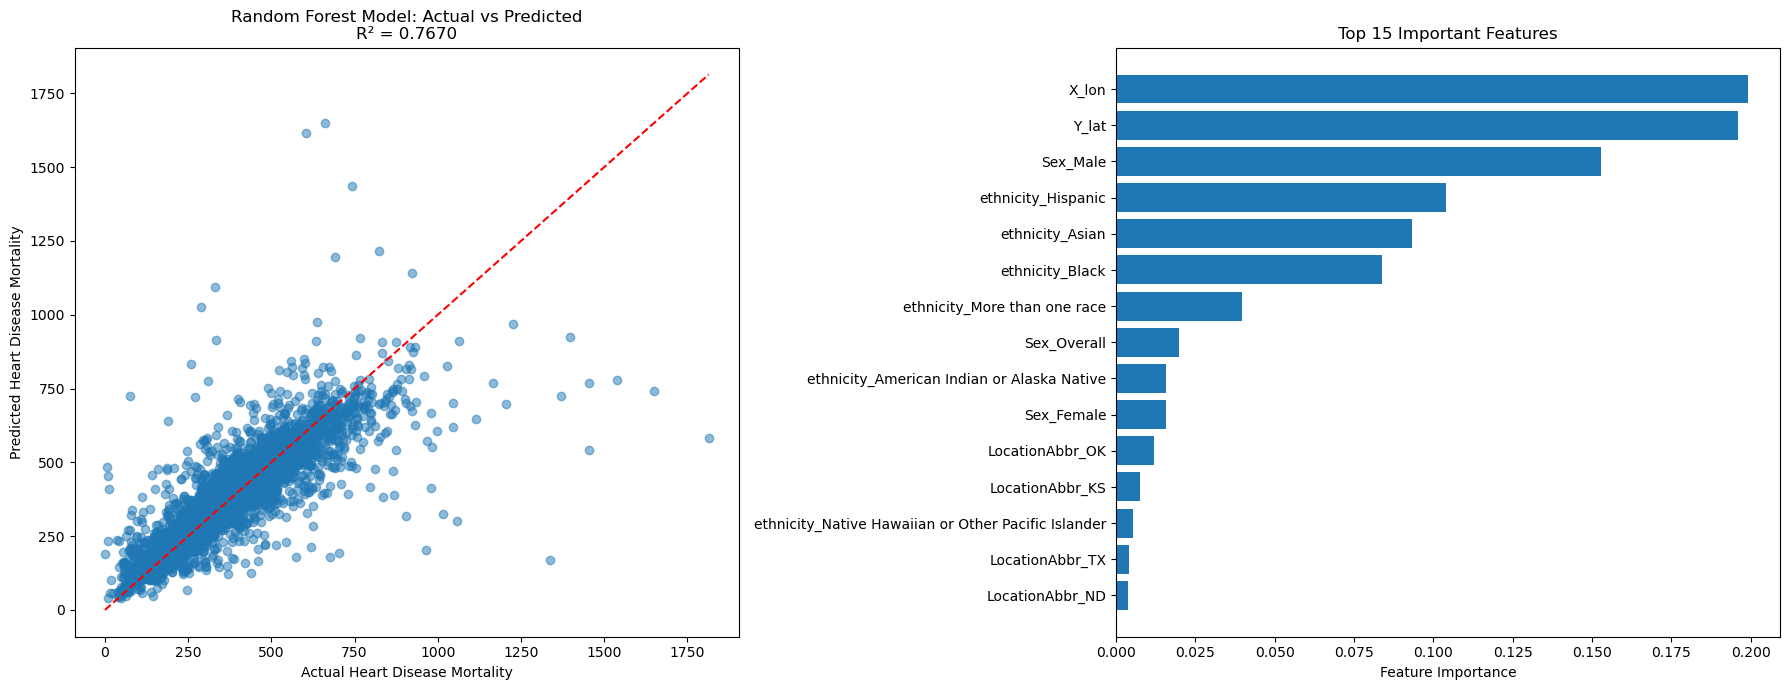

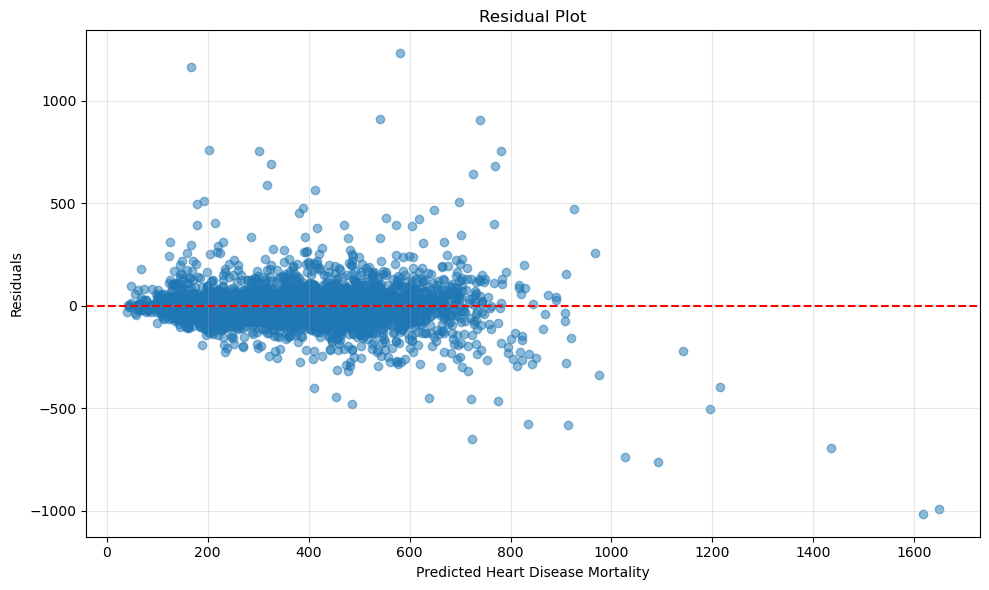

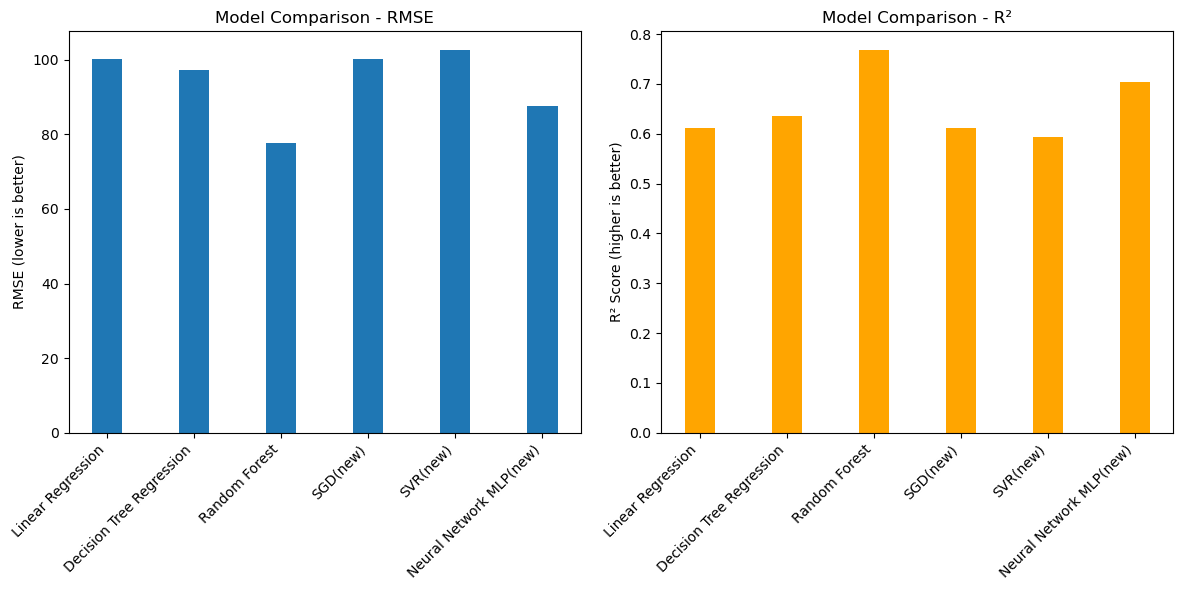

In [10]:
visualize_model_results(results, X_test, y_test, X_train)